### Importing Required Packages

In [0]:
from pyspark.sql.functions import *
import pyspark.sql.functions as f
import pyspark.sql.types as t
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

### Input Parameters

In [0]:
dbutils.widgets.removeAll()

In [0]:
dbutils.widgets.text("Country Name", "Germany")
dbutils.widgets.text("Product Name", "TRELEGY")
dbutils.widgets.text("Target DB Name", "opportunity_engine")
dbutils.widgets.text("Target Table Name Prefix", "aggregate_new")
dbutils.widgets.text("First Yearmonth", "202210")
dbutils.widgets.text("Second Yearmonth", "202211")
dbutils.widgets.text("Third Yearmonth", "202212")
dbutils.widgets.text("First DateYearmonth", "20221001")
dbutils.widgets.text("Second DateYearmonth", "20221101")
dbutils.widgets.text("Third DateYearmonth", "20221201")
dbutils.widgets.text("End DateYearmonth", "20230101")

In [0]:
country_name = dbutils.widgets.get("Country Name")
product_name = dbutils.widgets.get("Product Name")
tgt_dbname = dbutils.widgets.get("Target DB Name")
tgt_tblname_prefix = dbutils.widgets.get("Target Table Name Prefix")
first_yearmonth = dbutils.widgets.get("First Yearmonth")
second_yearmonth = dbutils.widgets.get("Second Yearmonth")
third_yearmonth = dbutils.widgets.get("Third Yearmonth")
first_dateyearmonth = dbutils.widgets.get("First DateYearmonth")
second_dateyearmonth = dbutils.widgets.get("Second DateYearmonth")
third_dateyearmonth = dbutils.widgets.get("Third DateYearmonth")
end_dateyearmonth = dbutils.widgets.get("End DateYearmonth")

In [0]:
#Setting to prevent OoM issue while handling large chunk of data
spark.conf.set("spark.sql.execution.arrow.enabled", "false")
spark.conf.set("spark.sql.execution.arrow.pyspark.fallback.enabled","false")

In [0]:
%run /OpportunityEngine/OpportunityEngine_Germany/Germany_Trelegy/Helper_Functions/config

In [0]:
lfa= spark.sql(f"select * from {tgt_dbname}.{tgt_tblname_prefix.lower()}_{country_name.lower()}_{product_name.lower()}")
lfa_df = lfa.toPandas()

#### Calculate Relative Trelegy Sales

In [0]:
lfa_df['TRELEGY_SALES'] = lfa_df["PREDICTED_SALES"]*lfa_df["SHARE_SITT"]*lfa_df["SHARE_TRELEGY"]

#### Multi Cycle Channel Plan data

In [0]:
#Yearly Cycleplan
cycleplan_year= spark.read.format('delta').load(f"/mnt/all_data_science_gen2_curated/Global/Activity/F_MC_CYCLE_PLAN_DETAIL/REGION=BIGEU/").filter(f.col('MARKETNAME')=='DEU').filter(f.col('DELETED_IND')==0).filter((f.col('START_DAY_ID')>=20220101) & (f.col('START_DAY_ID')<end_dateyearmonth))
cycleplan_year = cycleplan_year.select(f.col('ACCOUNT_ID'),f.col('USER_ID'))
cycleplan_year_df = cycleplan_year.toPandas()
cycleplan_year_df['USER_ID'] = cycleplan_year_df['USER_ID'].astype('string')
print(cycleplan_year_df)

        ACCOUNT_ID USER_ID
0         15356561   50551
1         14908221   48891
2         15678471   49731
3         60085501   15611
4           644161   36051
...            ...     ...
183044    16730591    2591
183045    13891351    2591
183046    14035611   14681
183047    16681781   14681
183048    16174511    2661

[183049 rows x 2 columns]


In [0]:
#First month Cycleplan
cycleplan_first= spark.read.format('delta').load(f"/mnt/all_data_science_gen2_curated/Global/Activity/F_MC_CYCLE_PLAN_DETAIL/REGION=BIGEU/").filter(f.col('MARKETNAME')=='DEU').filter(f.col('DELETED_IND')==0).filter((f.col('START_DAY_ID')>=first_dateyearmonth) & (f.col('START_DAY_ID')<second_dateyearmonth))
cycleplan_first = cycleplan_first.select(f.col('ACCOUNT_ID'),f.col('USER_ID'))
cycleplan_first_df = cycleplan_first.toPandas()
#Second month Cycleplan
cycleplan_second= spark.read.format('delta').load(f"/mnt/all_data_science_gen2_curated/Global/Activity/F_MC_CYCLE_PLAN_DETAIL/REGION=BIGEU/").filter(f.col('MARKETNAME')=='DEU').filter(f.col('DELETED_IND')==0).filter((f.col('START_DAY_ID')>=second_dateyearmonth) & (f.col('START_DAY_ID')<third_dateyearmonth))
cycleplan_second=cycleplan_second.select(f.col('ACCOUNT_ID'),f.col('USER_ID'))
cycleplan_second_df = cycleplan_second.toPandas()
#Third month Cycleplan
cycleplan_third= spark.read.format('delta').load(f"/mnt/all_data_science_gen2_curated/Global/Activity/F_MC_CYCLE_PLAN_DETAIL/REGION=BIGEU/").filter(f.col('MARKETNAME')=='DEU').filter(f.col('DELETED_IND')==0).filter((f.col('START_DAY_ID')>=third_dateyearmonth) & (f.col('START_DAY_ID')<end_dateyearmonth))
cycleplan_third=cycleplan_third.select(f.col('ACCOUNT_ID'),f.col('USER_ID'))
cycleplan_third_df = cycleplan_third.toPandas()
print(cycleplan_first_df)
print('*********************************************************************************************************************')
print(cycleplan_second_df)
print('*********************************************************************************************************************')
print(cycleplan_third_df)

      ACCOUNT_ID  USER_ID
0       16300571    60651
1       60338561    60651
2       14218101    53961
3       16765551    53961
4       13700761    53931
...          ...      ...
5625       50781    56831
5626      797801    56831
5627    13919691    56831
5628    14494451    56831
5629    15871161    56831

[5630 rows x 2 columns]
*********************************************************************************************************************
      ACCOUNT_ID  USER_ID
0       15278821    10791
1       13700801    61801
2       15199341    61801
3       16345801    61801
4       16924421    61801
...          ...      ...
9512    16295231    53941
9513    14156981    53941
9514    14611651    56831
9515    14677211    56831
9516      455011    61811

[9517 rows x 2 columns]
*********************************************************************************************************************
       ACCOUNT_ID  USER_ID
0        14181821    11021
1        14758111    11021
2        

#### Assessing the composition of each segment in Cluster_Rx

In [0]:
countA= lfa_df[lfa_df['RX_SEGMENT']=='A'].count().sum()/lfa_df.count().sum()
countB= lfa_df[lfa_df['RX_SEGMENT']=='B'].count().sum()/lfa_df.count().sum()
countC= lfa_df[lfa_df['RX_SEGMENT']=='C'].count().sum()/lfa_df.count().sum()
countD= lfa_df[lfa_df['RX_SEGMENT']=='D'].count().sum()/lfa_df.count().sum()
countE= lfa_df[lfa_df['RX_SEGMENT']=='E'].count().sum()/lfa_df.count().sum()
print('Percent of records in RX_Segment E is:',countE)
print('Percent of records in RX_Segment A is:',countA)
print('Percent of records in RX_Segment B is:',countB)
print('Percent of records in RX_Segment C is:',countC)
print('Percent of records in RX_Segment D is:',countD)

Percent of records in RX_Segment E is: 0.00928452776459421
Percent of records in RX_Segment A is: 0.06852159468438539
Percent of records in RX_Segment B is: 0.17403298528713812
Percent of records in RX_Segment C is: 0.511014871064705
Percent of records in RX_Segment D is: 0.21530414491377947


### Calculate the rank of HCPs in each Nanobrick per month and write to the database

In [0]:
###############################For whole year######################################################
mySchema = t.StructType([ t.StructField("ACCOUNT_ID", t.LongType(), True)\
                      ,t.StructField("RX_EU5_GSK_NANO_BRICK", t.StringType(), True)\
                      ,t.StructField("RX_SEGMENT", t.StringType(), True)\
                      ,t.StructField("RX_CUSTOMER_JOURNEY", t.StringType(), True)\
                      ,t.StructField("CALL_TYPE_WITH_MAX_INTERACTION", t.StringType(), True)\
                      ,t.StructField("USER_ID", t.StringType(), True)\
                      ,t.StructField("RANK", t.StringType(), True)\
                      ])
for i in [first_yearmonth,second_yearmonth,third_yearmonth]:
  hcp_rank=lfa_df[lfa_df['YEARMONTH'].astype(float)==float(i)]
  hcp_rank = hcp_rank[hcp_rank['Switch_toF2F']==1]
  hcp_rank_joined = hcp_rank.merge(cycleplan_year_df, on='ACCOUNT_ID', how='left')  
  hcp_rank_joined['USER_ID'] = hcp_rank_joined['USER_ID'].fillna(value='NA')
  hcp_rank_joined['PERCENTILE']=hcp_rank_joined['TRELEGY_SALES'].rank(pct=True)
  hcp_rank_joined['RANK'] = pd.cut(hcp_rank_joined['PERCENTILE'], bins=[0.0,0.75,0.92,0.99,1.0],labels=['Low','Medium','High','Critical'])
  hcp_rank_joined =hcp_rank_joined[["ACCOUNT_ID","RX_EU5_GSK_NANO_BRICK","RX_SEGMENT","RX_CUSTOMER_JOURNEY","CALL_TYPE_WITH_MAX_INTERACTION","USER_ID","RANK"]].sort_values(by=['RANK'],ascending=False)
  Py_rank =  spark.createDataFrame(hcp_rank_joined,schema=mySchema)
  Py_rank.write.mode("overwrite").option("mergeSchema", "true").saveAsTable(f"{tgt_dbname}.growth_yearlynew_{i}_{country_name.lower()}_{product_name.lower()}")
  Py_rank.unpersist()
  del(hcp_rank)
  del(hcp_rank_joined)


In [0]:
mySchema = t.StructType([ t.StructField("ACCOUNT_ID", t.LongType(), True)\
                      ,t.StructField("RX_EU5_GSK_NANO_BRICK", t.StringType(), True)\
                      ,t.StructField("RX_SEGMENT", t.StringType(), True)\
                      ,t.StructField("RX_CUSTOMER_JOURNEY", t.StringType(), True)\
                      ,t.StructField("CALL_TYPE_WITH_MAX_INTERACTION", t.StringType(), True)\
                      ,t.StructField("USER_ID", t.StringType(), True)\
                      ,t.StructField("RANK", t.StringType(), True)\
                      ])
for i in [first_yearmonth,second_yearmonth,third_yearmonth]:
  hcp_rank=lfa_df[lfa_df['YEARMONTH'].astype(float)==float(i)]
  hcp_rank = hcp_rank[hcp_rank['Switch_toF2F']==1]
  if i==first_yearmonth:
    hcp_rank_joined = hcp_rank.merge(cycleplan_first_df, on='ACCOUNT_ID', how='left')
  elif i==second_yearmonth:
    hcp_rank_joined = hcp_rank.merge(cycleplan_second_df, on='ACCOUNT_ID', how='left')
  elif i==third_yearmonth:
    hcp_rank_joined = hcp_rank.merge(cycleplan_third_df, on='ACCOUNT_ID', how='left')  
  hcp_rank_joined['PERCENTILE']=hcp_rank_joined['TRELEGY_SALES'].rank(pct=True)
  hcp_rank_joined['RANK'] = pd.cut(hcp_rank_joined['PERCENTILE'], bins=[0.0,0.75,0.92,0.99,1.0],labels=['Low','Medium','High','Critical'])
  hcp_rank_joined =hcp_rank_joined[["ACCOUNT_ID","RX_EU5_GSK_NANO_BRICK","RX_SEGMENT","RX_CUSTOMER_JOURNEY","CALL_TYPE_WITH_MAX_INTERACTION","USER_ID","RANK"]].sort_values(by=['RANK'],ascending=False)
  Py_rank =  spark.createDataFrame(hcp_rank_joined,schema=mySchema)
  Py_rank.write.mode("overwrite").option("mergeSchema", "true").saveAsTable(f"{tgt_dbname}.growth_new_{i}_{country_name.lower()}_{product_name.lower()}")
  Py_rank.unpersist()
  del(hcp_rank)
  del(hcp_rank_joined)


In [0]:
# spark.sql('drop table opportunity_engine.growth_new_202210_germany_trelegy')
# spark.sql('drop table opportunity_engine.growth_new_202211_germany_trelegy')
# spark.sql('drop table opportunity_engine.growth_new_202212_germany_trelegy')

#### Calculate the ratio of Segment and Rank to find overlap

In [0]:
for j in [first_yearmonth,second_yearmonth,third_yearmonth]:
  monthlydata = spark.sql(f"select * from {tgt_dbname}.growth_{j}_{country_name.lower()}_{product_name.lower()}")
  monthlydata_df = monthlydata.toPandas()
  num1=((monthlydata_df[(monthlydata_df['RX_SEGMENT']=='E') & (monthlydata_df['RANK']=='Critical')]).count()).sum()
  den1=(monthlydata_df[monthlydata_df['RANK']=='Critical'].count()).sum()
  ratio1 = num1/den1
  print('The ratio Segment-E and Rank Critical for the Yearmonth of %s is:%f'%(j,ratio1))
  num2=((monthlydata_df[(monthlydata_df['RX_SEGMENT']=='A') & (monthlydata_df['RANK']=='High')]).count()).sum()
  den2=(monthlydata_df[monthlydata_df['RANK']=='High'].count()).sum()
  ratio2 = num2/den2
  print('The ratio for Segment-A and Rank High for the Yearmonth of %s is:%f'%(j,ratio2))
  num3=((monthlydata_df[(monthlydata_df['RX_SEGMENT']=='B') & (monthlydata_df['RANK']=='Medium')]).count()).sum()
  den3=(monthlydata_df[monthlydata_df['RANK']=='Medium'].count()).sum()
  ratio3 = num3/den3
  print('The ratio for Segment-B and Rank Medium for the Yearmonth of %s is:%f'%(j,ratio3))
  ratio_combined = (num1+num2+num3)/(den1+den2+den3)
  print('The ratio for Segment-E,A,B and Rank for the Yearmonth of %s is:%f'%(j,ratio_combined))
  print("************************************************************************************")
  monthlydata.unpersist()
  del(monthlydata_df)

The ratio Segment-E and Rank Critical for the Yearmonth of 202210 is:0.130178
The ratio for Segment-A and Rank High for the Yearmonth of 202210 is:0.130564
The ratio for Segment-B and Rank Medium for the Yearmonth of 202210 is:0.213513
The ratio for Segment-E,A,B and Rank for the Yearmonth of 202210 is:0.186944
************************************************************************************
The ratio Segment-E and Rank Critical for the Yearmonth of 202211 is:0.131343
The ratio for Segment-A and Rank High for the Yearmonth of 202211 is:0.131390
The ratio for Segment-B and Rank Medium for the Yearmonth of 202211 is:0.216556
The ratio for Segment-E,A,B and Rank for the Yearmonth of 202211 is:0.189250
************************************************************************************
The ratio Segment-E and Rank Critical for the Yearmonth of 202212 is:0.167683
The ratio for Segment-A and Rank High for the Yearmonth of 202212 is:0.129427
The ratio for Segment-B and Rank Medium for the 

#### Analyze count of HCPs to target

In [0]:
Octdata = spark.sql(f"select * from {tgt_dbname}.growth_new_{first_yearmonth}_{country_name.lower()}_{product_name.lower()}")
Octdata_df =Octdata.toPandas()
Novdata = spark.sql(f"select * from {tgt_dbname}.growth_new_{second_yearmonth}_{country_name.lower()}_{product_name.lower()}")
Novdata_df =Novdata.toPandas()
Decdata = spark.sql(f"select * from {tgt_dbname}.growth_new_{third_yearmonth}_{country_name.lower()}_{product_name.lower()}")
Decdata_df =Decdata.toPandas()

In [0]:
#Getting the count of various ranks for Oct2022
print(pd.DataFrame(Octdata_df['RANK'].value_counts().values , Octdata_df['RANK'].value_counts().index))

            0
Low       213
Medium     49
High       20
Critical    3


In [0]:
#Getting the count of various ranks for Nov2022
print(pd.DataFrame(Novdata_df['RANK'].value_counts().values , Novdata_df['RANK'].value_counts().index))

            0
Low       138
Medium     31
High       13
Critical    2


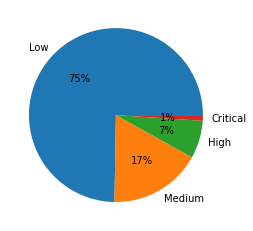

In [0]:
# plotting data on chart
plt.pie(Octdata_df['RANK'].value_counts().values, labels=Octdata_df['RANK'].value_counts().index, autopct='%.0f%%') 
# displaying chart
plt.show()